In [15]:
%matplotlib widget

CONFIG:
  ALPHAS_TO_TEST: [0.05, 0.2, 0.4, 0.6]
  POOL_SIZE: 500
  N_ASSETS: 60
  N_UNIVERSES: 100
  STABILITY range: 2019-01-01 -> 2024-01-01 | WINDOW_SIZE: 60
  OOS range: 2021-01-01 -> 2026-01-01 | Train years: 3 | Test years: 2



[*********************100%***********************]  500 of 500 completed

7 Failed downloads:
['HES', 'ANSS', 'BKW.AX', 'JNPR', 'AZPN', 'WBA']: YFTzMissingError('possibly delisted; no timezone found')
['FI']: YFPricesMissingError('possibly delisted; no price data found  (1d 2019-01-01 -> 2024-01-01) (Yahoo error = "No data found, symbol may be delisted")')


Kept 446 / 500 tickers with >= 95% coverage
Dropped 354 days with missing data; 952 days remain
✅ Retrieved 446 assets over 952 days
returns_stab_pool: (952, 446) | 2019-01-04 -> 2023-12-29

Universes sampled: 100 | assets per universe: 60

Running TEMPORAL STABILITY test (precision Θ)...
Stability computed for 100/100 universes.

Mean stability per alpha (lower = more stable):
  alpha=0.05    mean(||ΔΘ||/||Θ||) = 0.753990
  alpha=0.2     mean(||ΔΘ||/||Θ||) = 0.759174
  alpha=0.4     mean(||ΔΘ||/||Θ||) = 0.783721
  alpha=0.6     mean(||ΔΘ||/||Θ||) = 0.812733


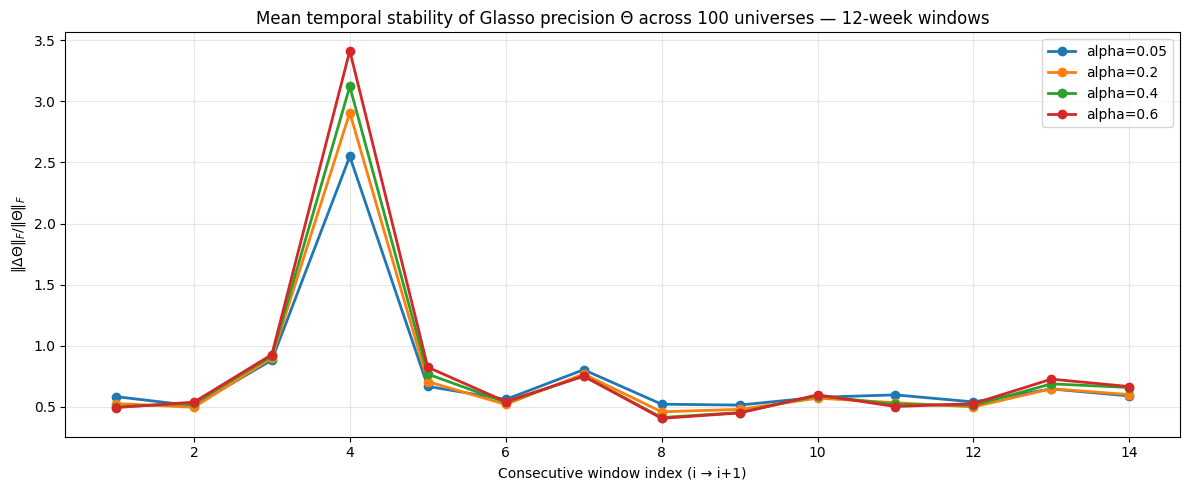

In [25]:
# ============================================================
# GLASSO HYPERPARAMETER COMPARISON (ALPHA GRID)
# 1) Temporal stability on precision Θ across consecutive windows
#    (compare alphas)
# 2) OOS GMV portfolio value
#    plot one curve per alpha with legend
# ============================================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.exceptions import ConvergenceWarning
import warnings

from utility import get_data, glasso

warnings.filterwarnings("ignore", category=ConvergenceWarning)

# ============================================================
# 0) Parameters
# ============================================================

ALPHAS_TO_TEST = [0.05, 0.2, 0.4, 0.6]   # grid of glasso alphas to compare
GLASSO_MAX_ITER = 300

# Universe sampling
POOL_SIZE = 500
N_ASSETS = 60
N_UNIVERSES = 100
PLOT_MEAN_ONLY = True   # plot mean across universes (True) or all universes (False)
MIN_COVERAGE = 0.95
RANDOM_SEED = 16
rng = np.random.RandomState(RANDOM_SEED)

# Stability windowing (for temporal stability test)
STAB_START_DATE = "2019-01-01"
STAB_END_DATE   = "2024-01-01"
WINDOW_WEEKS = 12
TRADING_DAYS_PER_WEEK = 5
WINDOW_SIZE = WINDOW_WEEKS * TRADING_DAYS_PER_WEEK

# OOS evaluation (for portfolio value comparison)
OOS_START_DATE = "2021-01-01"
OOS_END_DATE   = "2026-01-01"
TRAIN_YEARS = 3
TEST_YEARS  = 2

print("CONFIG:")
print("  ALPHAS_TO_TEST:", ALPHAS_TO_TEST)
print("  POOL_SIZE:", POOL_SIZE)
print("  N_ASSETS:", N_ASSETS)
print("  N_UNIVERSES:", N_UNIVERSES)
print("  STABILITY range:", STAB_START_DATE, "->", STAB_END_DATE, "| WINDOW_SIZE:", WINDOW_SIZE)
print("  OOS range:", OOS_START_DATE, "->", OOS_END_DATE, "| Train years:", TRAIN_YEARS, "| Test years:", TEST_YEARS)


# ============================================================
# 1) LOAD TICKERS + DOWNLOAD POOL (STABILITY RANGE)
# ============================================================
ALL_TICKERS = pd.read_csv("tickers_names.csv")["Ticker"].tolist()

if POOL_SIZE > len(ALL_TICKERS):
    raise ValueError(f"POOL_SIZE={POOL_SIZE} > number of tickers in CSV ({len(ALL_TICKERS)})")

pool_idx = rng.permutation(len(ALL_TICKERS))[:POOL_SIZE]
POOL_TICKERS = [ALL_TICKERS[i] for i in pool_idx]

print("\nDownloading returns pool for STABILITY test...")
returns_stab_pool = get_data(
    POOL_TICKERS,
    STAB_START_DATE,
    STAB_END_DATE,
    min_coverage=MIN_COVERAGE,
    fill_nan=False,
    save=False
)

print("returns_stab_pool:", returns_stab_pool.shape,
      "|", returns_stab_pool.index.min().date(), "->", returns_stab_pool.index.max().date())


# ============================================================
# 2) SAMPLE FIXED UNIVERSI (SAME FOR ALL ALPHAS)
# ============================================================
available_tickers = list(returns_stab_pool.columns)

if len(available_tickers) < N_ASSETS:
    raise ValueError(f"Not enough assets available ({len(available_tickers)}) for N_ASSETS={N_ASSETS}")

universes = []
for _ in range(N_UNIVERSES):
    tickers_i = rng.choice(available_tickers, size=N_ASSETS, replace=False)
    universes.append(list(tickers_i))

print("\nUniverses sampled:", len(universes), "| assets per universe:", N_ASSETS)


# ============================================================
# 3) HELPERS
# ============================================================
def split_into_windows(returns_df, window_size):
    n_samples = returns_df.shape[0]
    n_windows = n_samples // window_size
    windows = []
    for i in range(n_windows):
        start = i * window_size
        end = start + window_size
        windows.append(returns_df.iloc[start:end])
    return windows

def frobenius_differences(mat_list, eps=1e-12):
    """
    Normalized Frobenius diffs across consecutive windows:
      ||A_{t+1} - A_t||_F / ||A_t||_F
    """
    diffs = []
    for i in range(len(mat_list) - 1):
        A = mat_list[i]
        B = mat_list[i + 1]
        num = np.linalg.norm(B - A, ord="fro")
        den = np.linalg.norm(A, ord="fro")
        diffs.append(float(num / max(den, eps)))
    return np.array(diffs)

def min_variance_portfolio(Theta):
    ones = np.ones(Theta.shape[0])
    A = ones @ Theta @ ones
    if (not np.isfinite(A)) or (A <= 0):
        raise ValueError("Invalid A = 1' Theta 1.")
    return (Theta @ ones) / A

# ============================================================
# (A) TEMPORAL STABILITY TEST — compare ALPHAS
# PLOT PER UNIVERSE (subplots), and PRINT MEAN STABILITY per alpha
# ============================================================

print("\nRunning TEMPORAL STABILITY test (precision Θ)...")

# Store: per alpha -> list of arrays (one array per universe)
stability_by_alpha = {alpha: [] for alpha in ALPHAS_TO_TEST}
valid_universe_ids = []  # keep track of which universes actually got used

# Precompute stability series per universe, per alpha
for u_idx, tickers_i in enumerate(universes, start=1):
    df_u = returns_stab_pool[tickers_i].copy()
    df_u = df_u.dropna(axis=1, how="any")

    if df_u.shape[1] < max(5, int(0.7 * N_ASSETS)):
        print(f"Universe {u_idx}: skipped (too few assets after NaN-drop: {df_u.shape[1]})")
        continue

    windows_u = split_into_windows(df_u, WINDOW_SIZE)
    if len(windows_u) < 2:
        print(f"Universe {u_idx}: skipped (too few windows: {len(windows_u)})")
        continue

    # This universe is valid -> compute all alphas
    valid_universe_ids.append(u_idx)

    for alpha in ALPHAS_TO_TEST:
        glasso_precs = []
        for win in windows_u:
            _, g_prec = glasso(
                alpha=alpha,
                returns_df=win,
                save_outputs=False,
                max_iter=GLASSO_MAX_ITER
            )
            glasso_precs.append(g_prec)

        fro_glasso_prec = frobenius_differences(glasso_precs)
        stability_by_alpha[alpha].append(fro_glasso_prec)

print(f"Stability computed for {len(valid_universe_ids)}/{len(universes)} universes.")

# ------------------------------------------------------------
# PRINT mean stability per alpha (global number)
# ------------------------------------------------------------
print("\nMean stability per alpha (lower = more stable):")
for alpha in ALPHAS_TO_TEST:
    series_list = stability_by_alpha[alpha]
    if len(series_list) == 0:
        print(f"  alpha={alpha:<6}  mean(||ΔΘ||/||Θ||) = NaN  (no valid universes)")
        continue

    all_vals = np.concatenate([s for s in series_list if len(s) > 0])
    mean_val = float(np.mean(all_vals)) if len(all_vals) > 0 else np.nan
    print(f"  alpha={alpha:<6}  mean(||ΔΘ||/||Θ||) = {mean_val:.6f}")

# ------------------------------------------------------------
# PLOT: either per-universe subplots OR mean curve across universes
# (controlled by PLOT_MEAN_ONLY which is assumed already defined)
# ------------------------------------------------------------

if len(valid_universe_ids) == 0:
    raise RuntimeError("No valid universes available for plotting stability.")

# sanity: all valid universes must have same number of window-pairs (per alpha)
# we check using the first alpha as reference
ref_alpha = ALPHAS_TO_TEST[0]
ref_lengths = [len(s) for s in stability_by_alpha[ref_alpha]]
if len(set(ref_lengths)) != 1:
    raise RuntimeError(
        f"Valid universes have different stability lengths: {ref_lengths}. "
        "Cannot compute mean curve safely."
    )

n_pairs = ref_lengths[0]
x = np.arange(1, n_pairs + 1)

if PLOT_MEAN_ONLY:
    # ============================================================
    # SINGLE PLOT: mean stability curve across universes
    # one curve per alpha (mean across universes at each i->i+1)
    # ============================================================

    plt.figure(figsize=(12, 5))

    for alpha in ALPHAS_TO_TEST:
        series_list = stability_by_alpha[alpha]
        if len(series_list) == 0:
            continue

        M = np.vstack(series_list)          # shape: (n_valid_universes, n_pairs)
        mean_curve = np.mean(M, axis=0)

        plt.plot(x, mean_curve, marker="o", linewidth=2, label=f"alpha={alpha}")

    plt.title(
        f"Mean temporal stability of Glasso precision Θ across {len(valid_universe_ids)} universes "
        f"— {WINDOW_WEEKS}-week windows"
    )
    plt.xlabel("Consecutive window index (i → i+1)")
    plt.ylabel(r"$\|\Delta\Theta\|_F / \|\Theta\|_F$")
    plt.grid(alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

else:
    # ============================================================
    # SUBPLOTS: one plot per universe, multiple curves (alphas)
    # ============================================================
    ncols = 2
    nrows = int(np.ceil(len(valid_universe_ids) / ncols))

    fig, axes = plt.subplots(nrows, ncols, figsize=(16, 3.6 * nrows))
    axes = np.array(axes).flatten()

    for plot_idx, u_id in enumerate(valid_universe_ids):
        ax = axes[plot_idx]

        for alpha in ALPHAS_TO_TEST:
            series_list = stability_by_alpha[alpha]
            if len(series_list) <= plot_idx:
                continue

            s = series_list[plot_idx]
            ax.plot(x, s, marker="o", linewidth=2, label=f"alpha={alpha}")

        ax.set_title(f"Universe {u_id} — Glasso precision stability")
        ax.set_xlabel("Consecutive window index (i → i+1)")
        ax.set_ylabel(r"$\|\Delta\Theta\|_F / \|\Theta\|_F$")
        ax.grid(alpha=0.3)

    # turn off unused axes
    for j in range(len(valid_universe_ids), len(axes)):
        axes[j].axis("off")

    # Global legend once
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(
        handles, labels,
        loc="upper center",
        ncol=min(len(ALPHAS_TO_TEST), 6),
        frameon=False,
        bbox_to_anchor=(0.5, 1.02)
    )

    plt.suptitle(
        f"Temporal Stability of Glasso Precision Θ (per universe) — {WINDOW_WEEKS}-week windows",
        y=1.06,
        fontsize=14
    )
    plt.tight_layout()
    plt.show()




In [21]:
# OOS evaluation 
# Optional to run in between, to change some params
run = True

if run == True:
    OOS_START_DATE = "2021-01-01"
    OOS_END_DATE   = "2025-01-01"
    TRAIN_YEARS = 3
    TEST_YEARS  = 1
    N_UNIVERSES = 100
    RANDOM_SEED = 42
    N_ASSETS = 80



Running OOS GMV value comparison (Glasso alpha grid)...
  COMPUTE_EW: False
  PLOT_FIRST_K: 6
Train: 2021-01-01 -> 2023-12-31
Test : 2024-01-01 -> 2024-12-31



[*********************100%***********************]  500 of 500 completed

7 Failed downloads:
['HES', 'ANSS', 'BKW.AX', 'JNPR', 'AZPN', 'WBA']: YFTzMissingError('possibly delisted; no timezone found')
['FI']: YFPricesMissingError('possibly delisted; no price data found  (1d 2021-01-01 -> 2025-01-01) (Yahoo error = "No data found, symbol may be delisted")')


Kept 446 / 500 tickers with >= 95% coverage
Dropped 286 days with missing data; 757 days remain
✅ Retrieved 446 assets over 757 days
returns_oos_pool: (757, 446) | 2021-01-05 -> 2024-12-30

Universes for OOS: 100 universes, N_ASSETS=80 each

✅ OOS portfolio values computed for all universes and all alphas.


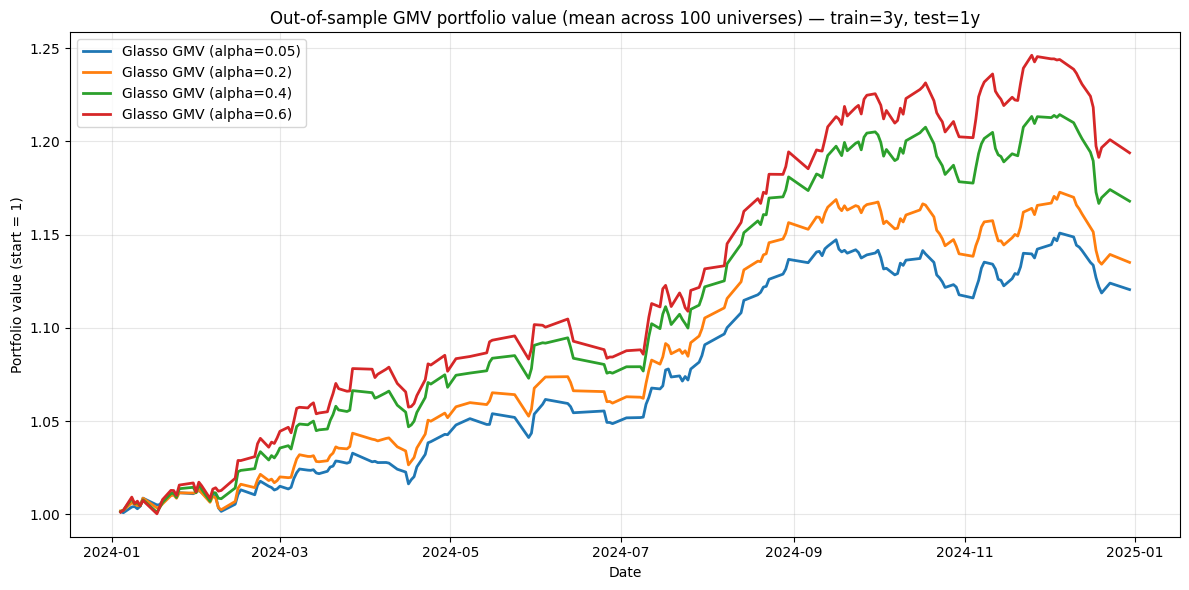


Final mean portfolio values (end of test):
  alpha=0.05  : 1.1205218370595025
  alpha=0.2   : 1.1350976048909958
  alpha=0.4   : 1.167918772161783
  alpha=0.6   : 1.193837503243401


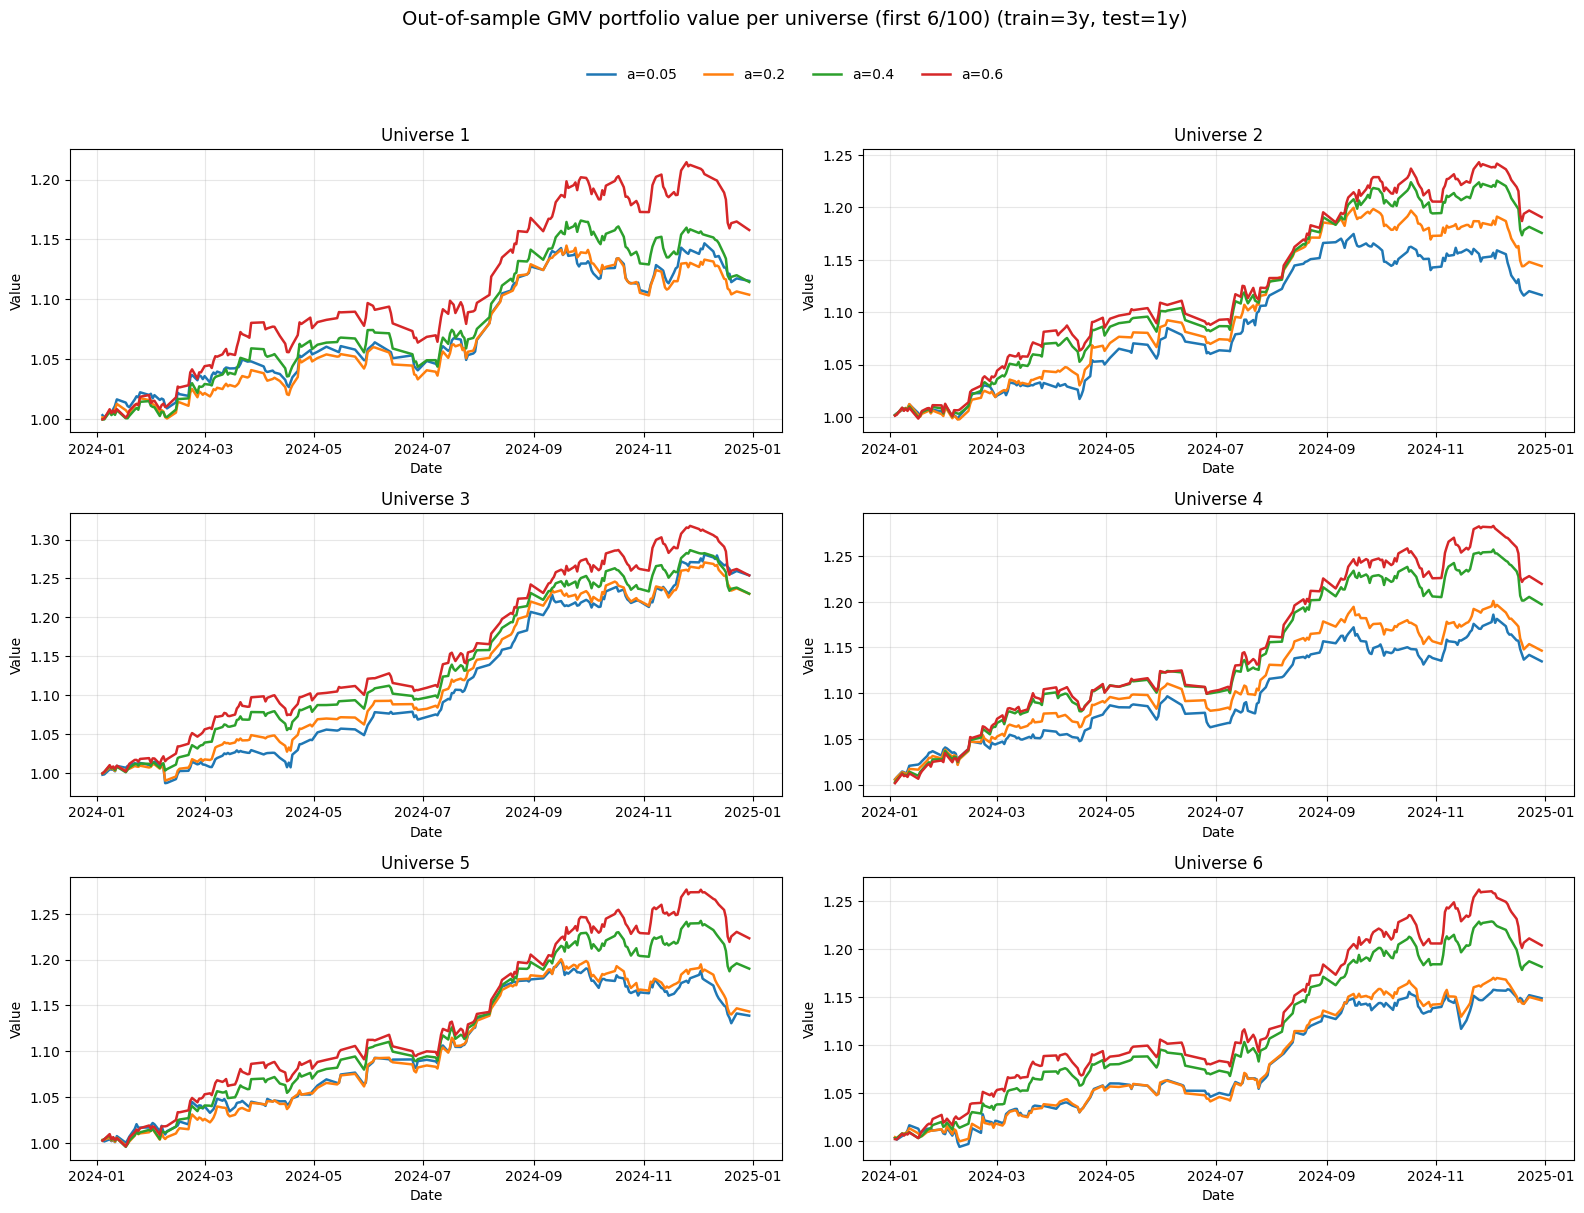

In [22]:
# ============================================================
# (B) OOS GMV PORTFOLIO VALUE — compare ALPHAS (Glasso only)
# Optional baseline: Equal Weight (EW)
# - Plot (1) mean across universes
# - Plot (2) first K universes separately (subplots)
# ============================================================

PLOT_FIRST_K = 6          # how many universes to show in subplot figure
COMPUTE_EW = False        # Compute Equal Weight

print("\nRunning OOS GMV value comparison (Glasso alpha grid)...")
print("  COMPUTE_EW:", COMPUTE_EW)
print("  PLOT_FIRST_K:", PLOT_FIRST_K)

# -----------------------------
# OOS split config
# -----------------------------
oos_start = pd.Timestamp(OOS_START_DATE)
oos_end   = pd.Timestamp(OOS_END_DATE)
train_end = oos_start + pd.DateOffset(years=TRAIN_YEARS)
test_end  = train_end + pd.DateOffset(years=TEST_YEARS)

if test_end > oos_end:
    raise ValueError("Not enough data for TRAIN_YEARS + TEST_YEARS inside the date range.")

print("Train:", oos_start.date(), "->", (train_end - pd.Timedelta(days=1)).date())
print("Test :", train_end.date(), "->", (test_end - pd.Timedelta(days=1)).date())

# -----------------------------
# Download OOS pool (because we need extended coverage)
# -----------------------------
print("\nDownloading returns pool for OOS test...")
returns_oos_pool = get_data(
    POOL_TICKERS,
    OOS_START_DATE,
    OOS_END_DATE,
    min_coverage=MIN_COVERAGE,
    fill_nan=False,
    save=False
).loc[oos_start:oos_end].copy()

print("returns_oos_pool:", returns_oos_pool.shape,
      "|", returns_oos_pool.index.min().date(), "->", returns_oos_pool.index.max().date())

if returns_oos_pool.isna().any().any():
    raise RuntimeError("returns_oos_pool still contains NaNs. Check get_data settings / coverage logic.")

# -----------------------------
# Sample universes DIRECTLY from OOS pool
# -----------------------------
available_oos_tickers = list(returns_oos_pool.columns)

if len(available_oos_tickers) < N_ASSETS:
    raise ValueError(f"Not enough assets in OOS pool ({len(available_oos_tickers)}) for N_ASSETS={N_ASSETS}")

universes_oos = []
for _ in range(N_UNIVERSES):
    tickers_u = rng.choice(available_oos_tickers, size=N_ASSETS, replace=False)
    universes_oos.append(list(tickers_u))

print(f"\nUniverses for OOS: {len(universes_oos)} universes, N_ASSETS={N_ASSETS} each")

# -----------------------------
# Helper: compute portfolio value from weights
# -----------------------------
def portfolio_value_series(test_returns_df, w):
    """
    test_returns_df: DataFrame (T x N)
    w: Series aligned to columns of test_returns_df
    """
    w = w.reindex(test_returns_df.columns)
    ret = test_returns_df.values @ w.values
    return pd.Series((1.0 + ret).cumprod(), index=test_returns_df.index)

# -----------------------------
# Storage
# -----------------------------
values_by_alpha_by_universe = {alpha: [] for alpha in ALPHAS_TO_TEST}

# Optional EW storage
values_EW_by_universe = [] if COMPUTE_EW else None

# -----------------------------
# Compute values for each universe
# -----------------------------
for u_idx, tickers_u in enumerate(universes_oos, start=1):
    df_u = returns_oos_pool[tickers_u].copy()

    train_mask = (df_u.index >= oos_start) & (df_u.index < train_end)
    test_mask  = (df_u.index >= train_end) & (df_u.index < test_end)

    train_returns = df_u.loc[train_mask]
    test_returns  = df_u.loc[test_mask]

    if train_returns.empty or test_returns.empty:
        raise RuntimeError(
            f"[OOS] Universe {u_idx}: empty train/test split. "
            f"Train rows={len(train_returns)}, Test rows={len(test_returns)}"
        )

    # -------------------------
    # Optional baseline: Equal Weight
    # -------------------------
    if COMPUTE_EW:
        n = train_returns.shape[1]
        w_ew = pd.Series(np.ones(n) / n, index=train_returns.columns)
        v_ew = portfolio_value_series(test_returns, w_ew)
        values_EW_by_universe.append(v_ew)

    # -------------------------
    # Glasso GMV for each alpha
    # -------------------------
    for alpha in ALPHAS_TO_TEST:
        try:
            _, glasso_prec = glasso(
                alpha=alpha,
                returns_df=train_returns,
                save_outputs=False,
                max_iter=GLASSO_MAX_ITER
            )
        except Exception as e:
            raise RuntimeError(f"[OOS] Universe {u_idx}, alpha={alpha}: glasso failed: {e}")

        try:
            w = min_variance_portfolio(glasso_prec)
        except Exception as e:
            raise RuntimeError(f"[OOS] Universe {u_idx}, alpha={alpha}: GMV weights failed: {e}")

        w = pd.Series(w, index=train_returns.columns)
        v = portfolio_value_series(test_returns, w)
        values_by_alpha_by_universe[alpha].append(v)

print("\n✅ OOS portfolio values computed for all universes and all alphas."
      + (" (EW baseline included)" if COMPUTE_EW else ""))

# ============================================================
# FIGURE 1: MEAN across universes
# ============================================================

plt.figure(figsize=(12, 6))

# Optional EW mean
if COMPUTE_EW:
    V_EW_mean = pd.concat(values_EW_by_universe, axis=1).mean(axis=1)
    plt.plot(V_EW_mean.index, V_EW_mean.values, linewidth=2, label="Equal Weight (EW)")

# Glasso mean curves
mean_value_by_alpha = {}
for alpha in ALPHAS_TO_TEST:
    mean_value_by_alpha[alpha] = pd.concat(values_by_alpha_by_universe[alpha], axis=1).mean(axis=1)
    mv = mean_value_by_alpha[alpha]
    plt.plot(mv.index, mv.values, linewidth=2, label=f"Glasso GMV (alpha={alpha})")

title_str = (
    f"Out-of-sample GMV portfolio value (mean across {N_UNIVERSES} universes) "
    f"— train={TRAIN_YEARS}y, test={TEST_YEARS}y"
)
plt.title(title_str)
plt.xlabel("Date")
plt.ylabel("Portfolio value (start = 1)")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

# Optional: print final values (mean)
print("\nFinal mean portfolio values (end of test):")
if COMPUTE_EW:
    print("  EW :", float(V_EW_mean.iloc[-1]))
for alpha in ALPHAS_TO_TEST:
    print(f"  alpha={alpha:<6}:", float(mean_value_by_alpha[alpha].iloc[-1]))

# ============================================================
# FIGURE 2: FIRST K universes (subplots)
# ============================================================

K = int(min(PLOT_FIRST_K, N_UNIVERSES))
if K <= 0:
    print("\nSkipping per-universe subplot figure (PLOT_FIRST_K <= 0).")
else:
    ncols = 2
    nrows = int(np.ceil(K / ncols))

    fig, axes = plt.subplots(nrows, ncols, figsize=(16, 3.8 * nrows))
    axes = np.array(axes).flatten()

    for u in range(K):
        ax = axes[u]

        # Optional EW
        if COMPUTE_EW:
            v_ew_u = values_EW_by_universe[u]
            ax.plot(v_ew_u.index, v_ew_u.values, linewidth=2, label="EW")

        # Glasso alphas
        for alpha in ALPHAS_TO_TEST:
            v_u = values_by_alpha_by_universe[alpha][u]
            ax.plot(v_u.index, v_u.values, linewidth=1.8, label=f"a={alpha}")

        ax.set_title(f"Universe {u+1}")
        ax.set_xlabel("Date")
        ax.set_ylabel("Value")
        ax.grid(alpha=0.3)

    # turn off unused axes
    for j in range(K, len(axes)):
        axes[j].axis("off")

    # Global legend once (clean)
    handles, labels = axes[0].get_legend_handles_labels()
    fig.legend(
        handles, labels,
        loc="upper center",
        ncol=min(10, len(labels)),
        frameon=False,
        bbox_to_anchor=(0.5, 1.02)
    )

    fig.suptitle(
        f"Out-of-sample GMV portfolio value per universe (first {K}/{N_UNIVERSES}) "
        f"(train={TRAIN_YEARS}y, test={TEST_YEARS}y)",
        y=1.06, fontsize=14
    )

    plt.tight_layout()
    plt.show()


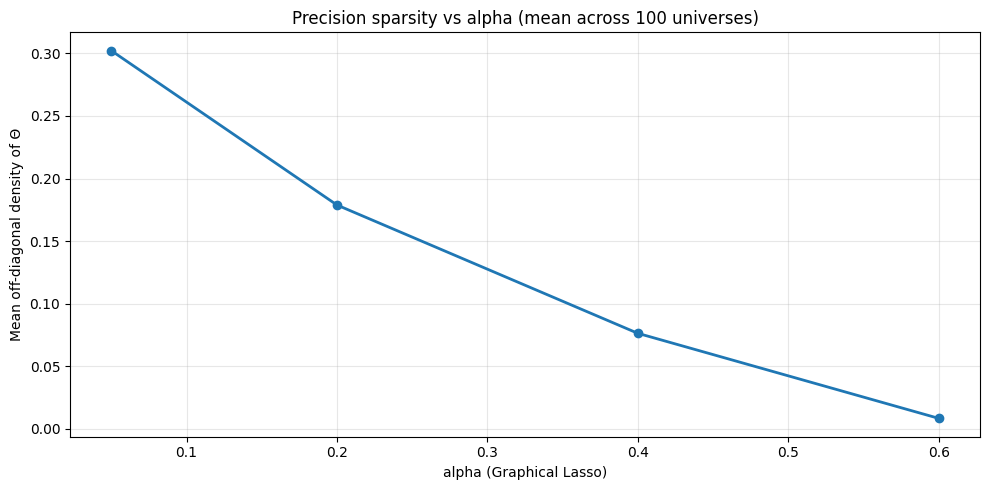

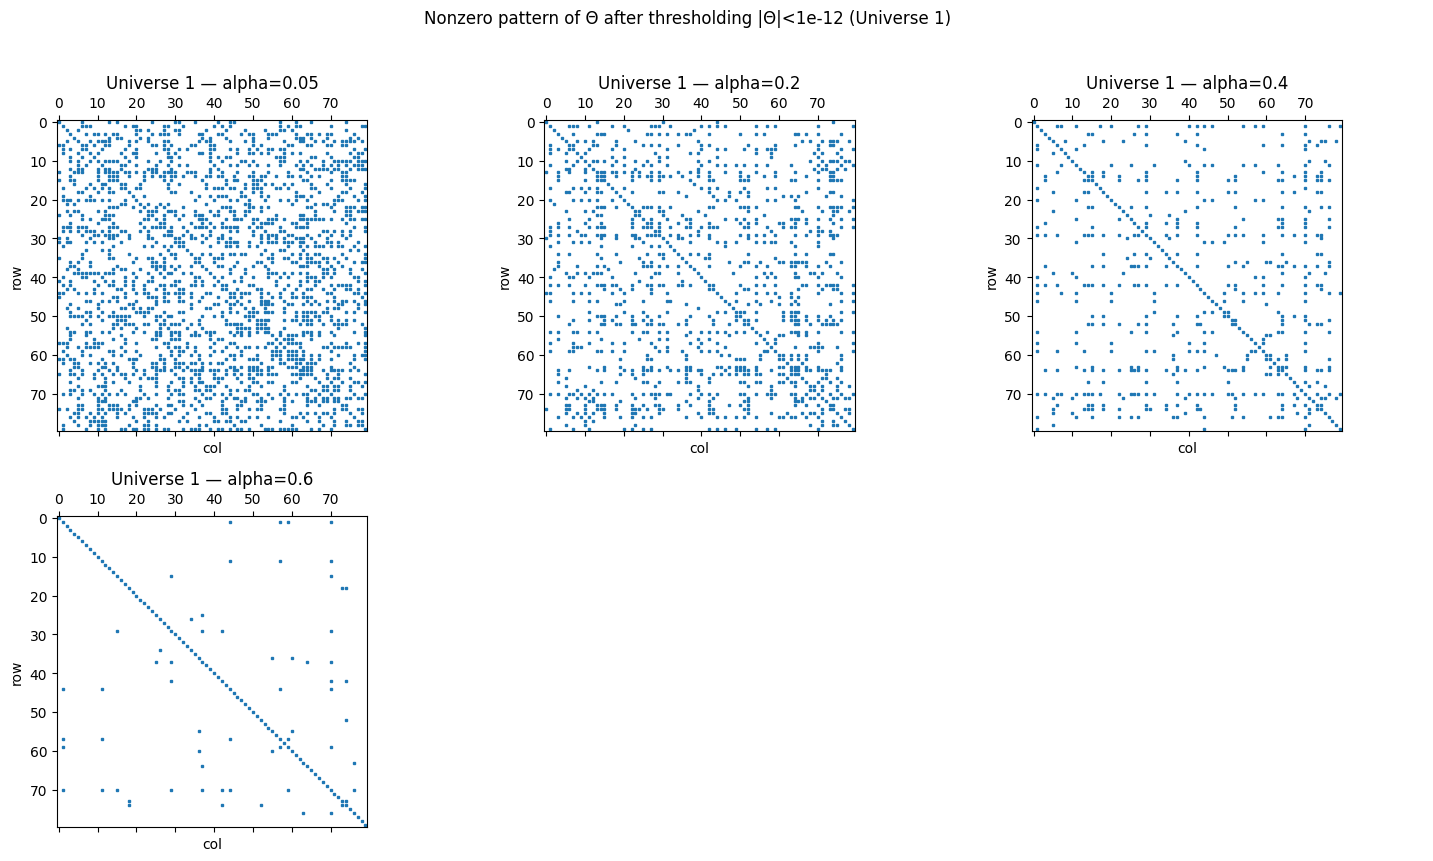

In [23]:
# ============================================================
# SPARSITY ANALYSIS (MINIMAL)
# 1) Plot: mean off-diagonal density of Θ vs alpha (across universes)
# 2) Plot: spy(Θ) per alpha for one selected universe
# ============================================================

import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# USER SETTINGS
# -----------------------------
SPARSITY_THRESHOLD = 1e-12     # treat abs(value) < threshold as zero
SHOW_UNIVERSE_IDX = 0         # 0-based index of universe to visualize

# -----------------------------
# sanity checks
# -----------------------------
required_vars = ["returns_oos_pool", "universes_oos", "ALPHAS_TO_TEST"]
for v in required_vars:
    if v not in globals():
        raise RuntimeError(f"Missing `{v}`. Run Part B first.")

if SHOW_UNIVERSE_IDX < 0 or SHOW_UNIVERSE_IDX >= len(universes_oos):
    raise ValueError(f"SHOW_UNIVERSE_IDX must be in [0, {len(universes_oos)-1}].")

# -----------------------------
# helper: off-diagonal density of Θ after thresholding
# -----------------------------
def offdiag_density(Theta, thr=1e-6):
    Theta = np.asarray(Theta)
    N = Theta.shape[0]

    Theta_thr = Theta.copy()
    Theta_thr[np.abs(Theta_thr) < thr] = 0.0

    nnz_total = int(np.count_nonzero(Theta_thr))
    diag_nnz = int(np.count_nonzero(np.diag(Theta_thr)))
    nnz_offdiag = nnz_total - diag_nnz

    offdiag_possible = N * N - N
    return float(nnz_offdiag / offdiag_possible)

# -----------------------------
# compute mean off-diagonal density vs alpha (across universes)
# Θ computed on TRAIN (same as in Part B)
# -----------------------------
oos_start = pd.Timestamp(OOS_START_DATE)
train_end = oos_start + pd.DateOffset(years=TRAIN_YEARS)

mean_offdiag_density = []

for alpha in ALPHAS_TO_TEST:
    densities = []

    for tickers_u in universes_oos:
        df_u = returns_oos_pool[tickers_u].copy()

        train_mask = (df_u.index >= oos_start) & (df_u.index < train_end)
        train_returns = df_u.loc[train_mask]

        if train_returns.empty:
            raise RuntimeError("[SPARSITY] Empty TRAIN set encountered.")

        _, Theta = glasso(
            alpha=alpha,
            returns_df=train_returns,
            save_outputs=False,
            max_iter=GLASSO_MAX_ITER
        )

        densities.append(offdiag_density(Theta, thr=SPARSITY_THRESHOLD))

    mean_offdiag_density.append(float(np.mean(densities)))

# -----------------------------
# PLOT 1: density vs alpha
# -----------------------------
plt.figure(figsize=(10, 5))
plt.plot(ALPHAS_TO_TEST, mean_offdiag_density, marker="o", linewidth=2)
plt.xlabel("alpha (Graphical Lasso)")
plt.ylabel("Mean off-diagonal density of Θ")
plt.title(f"Precision sparsity vs alpha (mean across {N_UNIVERSES} universes)")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# -----------------------------
# PLOT 2: spy plots for one universe (Θ pattern vs alpha)
# -----------------------------
tickers_show = universes_oos[SHOW_UNIVERSE_IDX]
df_show = returns_oos_pool[tickers_show].copy()

train_mask_show = (df_show.index >= oos_start) & (df_show.index < train_end)
train_show = df_show.loc[train_mask_show]

if train_show.empty:
    raise RuntimeError(f"[SPARSITY] SHOW_UNIVERSE_IDX={SHOW_UNIVERSE_IDX}: empty TRAIN set.")

n_alphas = len(ALPHAS_TO_TEST)
ncols = 3
nrows = int(np.ceil(n_alphas / ncols))

fig, axes = plt.subplots(nrows, ncols, figsize=(15, 4.2 * nrows))
axes = np.array(axes).flatten()

for i, alpha in enumerate(ALPHAS_TO_TEST):
    ax = axes[i]

    _, Theta = glasso(
        alpha=alpha,
        returns_df=train_show,
        save_outputs=False,
        max_iter=GLASSO_MAX_ITER
    )

    Theta[np.abs(Theta) < SPARSITY_THRESHOLD] = 0.0

    ax.spy(Theta, markersize=1.5)
    ax.set_title(f"Universe {SHOW_UNIVERSE_IDX+1} — alpha={alpha}")
    ax.set_xlabel("col")
    ax.set_ylabel("row")

for j in range(n_alphas, len(axes)):
    axes[j].axis("off")

plt.suptitle(
    f"Nonzero pattern of Θ after thresholding |Θ|<{SPARSITY_THRESHOLD} "
    f"(Universe {SHOW_UNIVERSE_IDX+1})",
    y=1.02
)
plt.tight_layout()
plt.show()
